GPLearn

<>:72: SyntaxWarning: invalid escape sequence '\/'
<>:72: SyntaxWarning: invalid escape sequence '\/'
C:\Users\emili\AppData\Local\Temp\ipykernel_30572\1334443036.py:72: SyntaxWarning: invalid escape sequence '\/'
  score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)


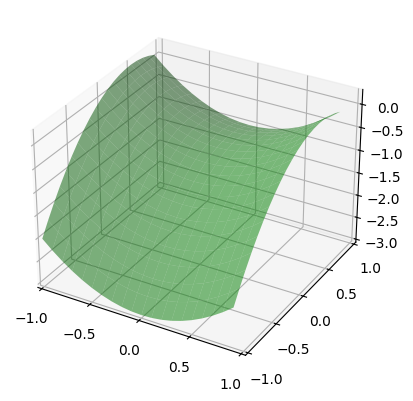

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.578        5         0.320666         0.556764      1.90m
   1     9.97          1.70233        5         0.320202         0.624787      1.19m
   2     7.72          1.94456       11         0.239537         0.533148      1.17m
   3     5.41         0.990157        7         0.235676         0.719906     56.01s
   4     4.66         0.894443       11         0.103946         0.103946     54.01s
   5     5.41         0.940242       11         0.060802         0.060802     47.59s
   6     6.78          1.09536       11      0.000781474      0.000781474     44.64s
sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))


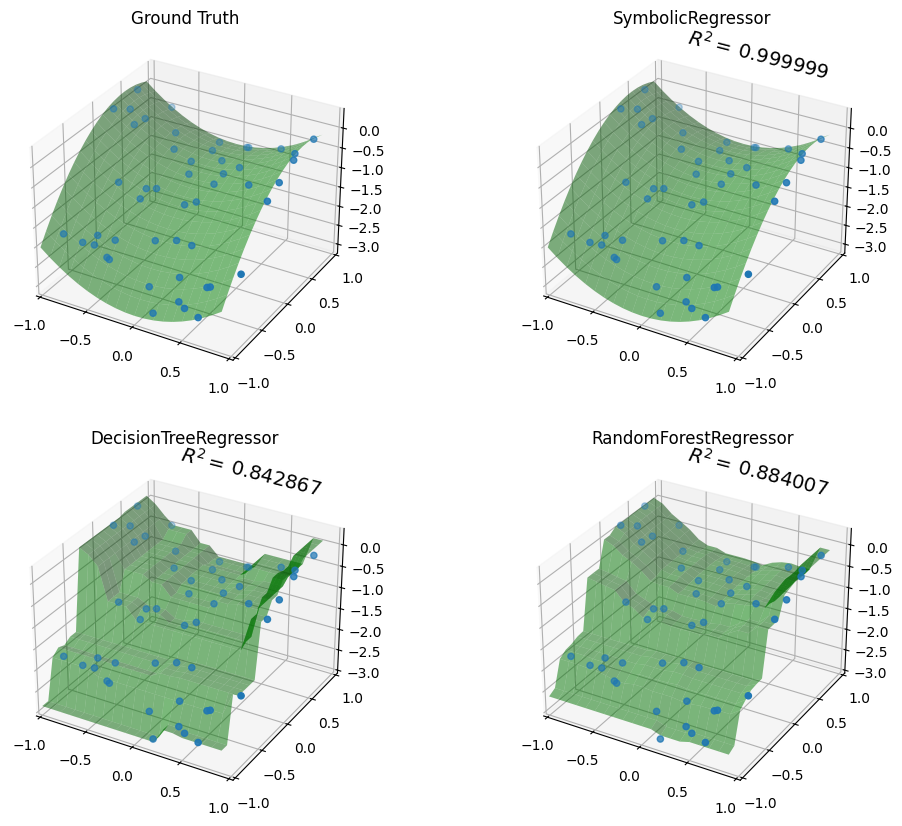

C:\Users\emili\AppData\Local\Temp\ipykernel_30572\1334443036.py:72: SyntaxWarning: invalid escape sequence '\/'
  score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [4]:
%matplotlib inline
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import graphviz

# Ground truth
x0 = np.arange(-1, 1, .1)
x1 = np.arange(-1, 1, .1)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks(np.arange(-1, 1.01, .5))
ax.set_yticks(np.arange(-1, 1.01, .5))
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1, color='green', alpha=0.5)
plt.show()

rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

print(est_gp._program)

est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)
est_rf = RandomForestRegressor(n_estimators=10)
est_rf.fit(X_train, y_train)

y_gp = est_gp.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)
score_rf = est_rf.score(X_test, y_test)

fig = plt.figure(figsize=(12, 10))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                       (y_gp, score_gp, "SymbolicRegressor"),
                                       (y_tree, score_tree, "DecisionTreeRegressor"),
                                       (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(-1, 1.01, .5))
    ax.set_yticks(np.arange(-1, 1.01, .5))
    surf = ax.plot_surface(x0, x1, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=14)
    plt.title(title)

plt.show()

dot_data = est_gp._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex1_child', format='png', cleanup=True)
graph

print(est_gp._program.parents)

idx = est_gp._program.parents['donor_idx']
fade_nodes = est_gp._program.parents['donor_nodes']
print(est_gp._programs[-2][idx])
print('Fitness:', est_gp._programs[-2][idx].fitness_)
dot_data = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = graphviz.Source(dot_data)
graph

idx = est_gp._program.parents['parent_idx']
fade_nodes = est_gp._program.parents['parent_nodes']
print(est_gp._programs[-2][idx])
print('Fitness:', est_gp._programs[-2][idx].fitness_)
dot_data = est_gp._programs[-2][idx].export_graphviz(fade_nodes=fade_nodes)
graph = graphviz.Source(dot_data)
graph

Deap

In [7]:
import operator
import math
import random

import numpy as np
from functools import partial
from deap import algorithms, base, creator, tools, gp

# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

# Define the set of primitives with two arguments (x and y)
pset = gp.PrimitiveSet("MAIN", 2)  # Two inputs now (x and y)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", partial(random.randint, -1, 1))

# Rename the arguments to x and y
pset.renameArguments(ARG0='x')
pset.renameArguments(ARG1='y')

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Update the evaluation function for the new expression f(x, y) = x^3 * 5y^2 + x/2
def evalSymbReg(individual, points):
    func = toolbox.compile(expr=individual)
    sqerrors = ((func(x, y) - (x**3 * 5 * y**2 + x / 2))**2 for x, y in points)
    return math.fsum(sqerrors) / len(points),

# Generate random points for x and y in the range [-10, 10]
points = [(x/10., y/10.) for x in range(-10, 10) for y in range(-10, 10)]
toolbox.register("evaluate", evalSymbReg, points=points)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

def main():
    random.seed(318)

    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats,
                                   halloffame=hof, verbose=True)
    
    # Print the best individual and its fitness
    print("Best individual is: ", hof[0])
    print("With fitness: ", hof[0].fitness.values)
    return pop, log, hof

if __name__ == "__main__":
    main()


c:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\emili\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max   	min     	nevals	std    	avg 	gen	max	min	nevals	std    
0  	300   	2.9682	0  	58.872	0.483527	300   	5.01473	3.61	0  	7  	2  	300   	1.43686
1  	155   	1.50992	1  	14.7652	0.483527	155   	1.30208	3.67333	1  	15 	1  	155   	1.8129 
2  	149   	1.10555	2  	6.61581	0.44267 	149   	0.644479	3.70333	2  	10 	1  	149   	1.88202
3  	167   	0.880737	3  	2.52699	0.44267 	167   	0.531206	3.70667	3  	10 	1  	167   	1.92889
4  	173   	0.810987	4  	5.7335 	0.44267 	173   	0.635868	3.78333	4  	13 	1  	173   	1.98067
5  	177   	0.729628	5  	7.39738	0.44267 	177   	0.598099	3.87333	5  	12 	1  	177   	1.80849
6  	157   	0.655584	6  	6.62458	0.44267 	157   	0.636981	4.11333	6  	11 	1  	157   	1.59389
7  	168   	0.641901	7  	5.70524	0.44267 	168   	0.4